# Converts the JHU Cumulative Case Count Data to Daily Case Count Data

# TO DO:
- [ ] Research random effects models in time to event studies 
- [ ] **The long versions of the death and case datasets have 55,100 rows, but the final data frame has 66,797. Need to understand why and correct, if this is no appropriate**
- [ ] **Need to run PCA to justify the method of making SDI**




## Completed
- [X] Create the social distancing metric for the cumulative incidence data set Calculated as the total number of days with social distancing implemented (either before peak transmission or X # of days after peak transmission (what is the longest recorded in the data set???)* the ordinal value of the social distancing measure, scaled so that the highest recorded value is 100.
- [X] Calculate the daily case per 100k population
- [X] Calculate the daily death per 100k population
- [X] Create the data set that will have the cumulative incidence
- [X] **BUT READ** [**THIS ARTICLE**](https://doi.org/10.1101/2020.07.04.20145334) first. It might give you ideas for how to calculate the control measures vars.
- [X] Merge in population density data
- [X] Lag the rolling mean case & death counts to the serial interval for COVID
- [X] Create a data set that will be used for the time to event study. Day 1 for all countries will be the date of their 1st reported case.
- [X] There seems to be a problem with the rolling mean calculations. It seems like they are calculated backwards. Probably an issue with the sort before they were created. Make sure they are sorted by country, date
- [X] Figure out how to fix the control measure obs that are recorded as '.'
- [X] Need to explore the missingness of the Oxford data. Sort the countries by GDP and examine what the missingness matrix looks like. **If you could run imputation on this data then you would have a major leg up on the other paper working on the similar topic. (on to of the other benefits to your paper)**
- [X] Write the code that merges in the time series data for the diffent control measures
- [X] Write the code merges in the Country Safety Index data
- [X] Continue to update this **[file](https://1drv.ms/x/s!AjWX5HOdYY23kf9x5S7g8LKLGlseVg?e=992nsi)** of data source locations 
- [X] Write the code that lets you convert the US data to long
- [X] Write the code that converts the column names in the Oxford data set to match the column names in the JHU dat
- [X] Write the code that merges the countries to their offical alpha 3 code in the JHU: **[Link to Codes](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes)**
- [X] **ALTERNATIVE TO ABOVE** use python-Levenshtein [Docs](https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html) distance to match similar country names 
> would still need to pair the high probability matches 
- [X] Write the code transposes the combined data with the control measures included

In [111]:
import pandas as pd
import os
import sys
import shutil
import re
import numpy as np

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15 ,9
import seaborn as sns
from matplotlib.pyplot import figure


In [113]:
def Correcting_Col_Names(infile_path, dset):
    infile = pd.read_csv(infile_path)
    # og_col_list = infile.columns.to_list()
    df = pd.DataFrame(infile.columns.to_list())
    df['col'] = df[2:].apply(lambda x: pd.to_datetime(x).dt.strftime('X%m/X%d/%Y').str.replace('X0','').str.replace('X',''))
    df['col'][0] = 'country'
    df['col'][1] = 'country_code'
    cols = df.col.to_list()
    control = pd.read_csv(infile_path, names = cols, skiprows={0:1})
    indexNames = control[ control['country_code'].isna()].index
    control.drop(indexNames, inplace=True)
    df = controls_transpose(control, dset)
    return df

In [114]:
def controls_transpose(dset, var):
    import re
    df = dset.T
    df.columns = df.iloc[0]
    df.columns =df.columns.str.lower()
    df.drop(axis=0, index = {'country', 'country_code'},inplace = True)
    df = df.reset_index().rename(columns={'index':'date'})
    df = long_maker(df, var)
    df.loc[df['country'].str.contains('cape verde',flags= re.IGNORECASE), 'country']= 'cabo verde'
    df.loc[df['country'].str.contains('taiwan',flags= re.IGNORECASE), 'country']= 'taiwan'
    return df

In [115]:
def df_merger(df):
    global long_df
    long_df = long_df.merge(df, on=['date', 'country'],how='outer')
    return long_df

In [116]:
def our_world_importer(filename,sheet, year=2017):
    df = pd.read_excel(f'{control_data_path}\\{filename}.xlsx', sheet_name = sheet)
    df = stats_col_renamer(df)
    df = df.loc[df.year == year]
    df.drop(columns=['entity','year'],inplace=True)
    df.dropna(how='any',inplace=True)
    return df

In [117]:
def long_maker(dset, var):
    name_list = dset.columns.to_list()[1:]
    long_df = pd.DataFrame(columns = {'date', var, 'country'})
    for name in name_list:
        df = dset.filter(items={name, 'date'})
        df['country'] = name
        df.rename(columns={name:var},inplace = True)
        long_df = pd.concat([long_df, df],axis=0)
    long_df.date = pd.to_datetime(long_df.date)
    return long_df.reset_index(drop=True)

In [118]:
def peak_date_cleaner(df, peak_id, peak_date, date_offset=1):
    """ Removes the countries with multiple peak dates from the data set
    
    """
    df_multi_peak_country = df.loc[(df[peak_id] == 1)].groupby('country')[peak_date].nunique().to_frame()
    two_peaks_country = df_multi_peak_country.loc[df_multi_peak_country[peak_date] ==2].index
    date_ranges = pd.DataFrame(df.loc[(df[peak_id] == 1)].groupby('country')[peak_date].max() - df.loc[(df[peak_id] == 1)].groupby('country')[peak_date].min()) 
    date_ranges.rename(columns={peak_date:'peak_range'},inplace =True)
    date_ranges.reset_index(inplace=True)
    df = df.merge(date_ranges,on='country',how='outer')
    df.loc[df.peak_range > pd.to_timedelta('1 day'), f'{peak_date}'] = (finaldf.date.dt.date.max() + pd.DateOffset(days=date_offset))
    df.sort_values(by = f'{peak_date}',inplace=True)
    df['dup'] = df.duplicated('country',keep='first')
    df = df.loc[~df.dup]
    df = df.drop(columns=['dup', 'peak_range'])
    return df,  date_offset

In [119]:
def stats_col_renamer(dframe):
    """
    Tips: This fuction will remove special characters from column headers, replace spaces with columns, 
    and make all heading lower case

    Parameters
    ----------
    dframe : TYPE Pandas dataframe
        DESCRIPTION.

    Returns
    -------
    None.

    """
    
    dframe.columns = dframe.columns.str.lower()
    dframe.columns = dframe.columns.str.replace('\s{2,}',' ',regex=True).str.replace('-',' ').str.replace(' ','_').str.replace('[^A-Za-z0-9_]+','',regex=True)
    return dframe
data_path = r'..\csse_covid_19_data\csse_covid_19_time_series'
out_data_path = r'..\Modified Data Sets'
control_data_path = '..\Control Data'
case_pre = pd.read_csv(f'{data_path}/time_series_covid19_confirmed_global.csv')
death_pre = pd.read_csv(f'{data_path}/time_series_covid19_deaths_global.csv')

## Importing the JHU COVID Case Data

In [120]:
# case_pre_us = pd.read_csv(f'{data_path}/time_series_covid19_confirmed_US.csv')
# death_pre_us = pd.read_csv(f'{data_path}/time_series_covid19_deaths_US.csv')


file_list = os.listdir(out_data_path)
for files in file_list:
    if files.find('.xlsx') >= 0:
        shutil.move(f'{out_data_path}/{files}',f'{out_data_path}/ARCHIVE/{files}')
def DF_Transform(df, outcome):
    global data_path
    global out_data_path
    
    # Data Cleaning
    df.drop(labels={'Lat','Long'},axis=1, inplace = True)
#     df.loc[df['Country/Region'].str.contains('Congo'), 'Country/Region'] ='Congo'
    df.loc[df['Country/Region'].str.contains('Korea, South',flags= re.IGNORECASE), 'Country/Region']= 'South Korea'
    df.loc[df['Country/Region'] == ('US'), 'Country/Region']= 'United States'
    df.loc[df['Country/Region'].str.contains('taiwan',flags= re.IGNORECASE), 'Country/Region']= 'taiwan'
    # Data Manipulation
    df = df.groupby(by='Country/Region').sum().T.apply(lambda x: x-x.shift(1),axis=0)
    df.rename(columns={'Country/Region':'Date'},inplace=True)
    df.columns = df.columns.str.lower()
    df = df.reset_index()
    df.rename(columns={'index':'date'},inplace= True)
    df.date = pd.to_datetime(df.date).dt.date
#     df['var'] = outcome[16:]
    
    filename = f'{out_data_path}/{outcome} (Through {df.date.max()}).xlsx'
    df.to_excel(filename, index=False)
    return df
case = DF_Transform(case_pre, 'Global COVID-19 Case Count')
death = DF_Transform(death_pre, 'Global COVID-19 Death Count')
# case = DF_Transform(case_pre_us, 'US COVID-19 Case Count')
# death = DF_Transform(death_pre_us, 'US COVID-19 Death Count')

In [121]:
long_case = long_maker(case, 'case_count')
long_death = long_maker(death, 'death_count')

In [122]:
case_lag_d = case.set_index('date')
case_lag1 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-1),axis=0).reset_index()
case_lag2 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-2),axis=0).reset_index()
case_lag3 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-3),axis=0).reset_index()
case_lag4 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-4),axis=0).reset_index()
case_lag5 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-5),axis=0).reset_index()
case_lag6 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-6),axis=0).reset_index()
case_lag7 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-7),axis=0).reset_index()
case_lag8 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-8),axis=0).reset_index()
case_lag9 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-9),axis=0).reset_index()
case_lag10 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-10),axis=0).reset_index()
case_lag11 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-11),axis=0).reset_index()
case_lag12 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-12),axis=0).reset_index()
case_lag13 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-13),axis=0).reset_index()
case_lag14 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-14),axis=0).reset_index()
case_lag15 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-15),axis=0).reset_index()
case_lag16 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-16),axis=0).reset_index()
case_lag17 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-17),axis=0).reset_index()
case_lag18 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-18),axis=0).reset_index()
case_lag19 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-19),axis=0).reset_index()
case_lag20 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-20),axis=0).reset_index()
case_lag21 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-21),axis=0).reset_index()

death_lag_d = death.set_index('date')
death_lag1 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-1),axis=0).reset_index()
death_lag2 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-2),axis=0).reset_index()
death_lag3 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-3),axis=0).reset_index()
death_lag4 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-4),axis=0).reset_index()
death_lag5 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-5),axis=0).reset_index()
death_lag6 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-6),axis=0).reset_index()
death_lag7 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-7),axis=0).reset_index()
death_lag8 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-8),axis=0).reset_index()
death_lag9 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-9),axis=0).reset_index()
death_lag10 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-10),axis=0).reset_index()
death_lag11 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-11),axis=0).reset_index()
death_lag12 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-12),axis=0).reset_index()
death_lag13 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-13),axis=0).reset_index()
death_lag14 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-14),axis=0).reset_index()
death_lag15 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-15),axis=0).reset_index()
death_lag16 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-16),axis=0).reset_index()
death_lag17 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-17),axis=0).reset_index()
death_lag18 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-18),axis=0).reset_index()
death_lag19 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-19),axis=0).reset_index()
death_lag20 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-20),axis=0).reset_index()
death_lag21 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-21),axis=0).reset_index()

In [123]:
long_1 = long_maker(case_lag1,'case1')
long_2 = long_maker(case_lag2,'case2')
long_3 = long_maker(case_lag3,'case3')
long_4 = long_maker(case_lag4,'case4')
long_5 = long_maker(case_lag5,'case5')
long_6 = long_maker(case_lag6,'case6')
long_7 = long_maker(case_lag7,'case7')
long_8 = long_maker(case_lag8,'case8')
long_9 = long_maker(case_lag9,'case9')
long_10 = long_maker(case_lag10,'case10')
long_11 = long_maker(case_lag11,'case11')
long_12 = long_maker(case_lag12,'case12')
long_13 = long_maker(case_lag13,'case13')
long_14 = long_maker(case_lag14,'case14')
long_15 = long_maker(case_lag15,'case15')
long_16 = long_maker(case_lag16,'case16')
long_17 = long_maker(case_lag17,'case17')
long_18 = long_maker(case_lag18,'case18')
long_19 = long_maker(case_lag19,'case19')
long_20 = long_maker(case_lag20,'case20')
long_21 = long_maker(case_lag21,'case21')   

In [124]:
death_long_1 = long_maker(death_lag1,'death1')
death_long_2 = long_maker(death_lag2,'death2')
death_long_3 = long_maker(death_lag3,'death3')
death_long_4 = long_maker(death_lag4,'death4')
death_long_5 = long_maker(death_lag5,'death5')
death_long_6 = long_maker(death_lag6,'death6')
death_long_7 = long_maker(death_lag7,'death7')
death_long_8 = long_maker(death_lag8,'death8')
death_long_9 = long_maker(death_lag9,'death9')
death_long_10 = long_maker(death_lag10,'death10')
death_long_11 = long_maker(death_lag11,'death11')
death_long_12 = long_maker(death_lag12,'death12')
death_long_13 = long_maker(death_lag13,'death13')
death_long_14 = long_maker(death_lag14,'death14')
death_long_15 = long_maker(death_lag15,'death15')
death_long_16 = long_maker(death_lag16,'death16')
death_long_17 = long_maker(death_lag17,'death17')
death_long_18 = long_maker(death_lag18,'death18')
death_long_19 = long_maker(death_lag19,'death19')
death_long_20 = long_maker(death_lag20,'death20')
death_long_21 = long_maker(death_lag21,'death21')

## Importing the Oxford Control Variables

In [125]:
c_measures_path = r'../../../covid-policy-tracker/data'
school = Correcting_Col_Names(f'{c_measures_path}/timeseries/c1_schoolclosing.csv', 'school_close')
work = Correcting_Col_Names(f'{c_measures_path}/timeseries/c2_workplaceclosing.csv', 'work_close')
pub_events = Correcting_Col_Names(f'{c_measures_path}/timeseries/c3_cancelpublicevents.csv', 'public_events')
gatherings = Correcting_Col_Names(f'{c_measures_path}/timeseries/c4_restrictionsongatherings.csv', 'large_gather')
pub_transpo = Correcting_Col_Names(f'{c_measures_path}/timeseries/c5_closepublictransport.csv', 'public_transpo')
stay_home = Correcting_Col_Names(f'{c_measures_path}/timeseries/c6_stayathomerequirements.csv' ,'stay_home')
domestic_travel = Correcting_Col_Names(f'{c_measures_path}/timeseries/c7_domestictravel.csv' ,'domestic_travel')
int_travel = Correcting_Col_Names(f'{c_measures_path}/timeseries/c8_internationaltravel.csv' ,'internat_travel')

In [126]:
#Old merge statment
long_df = long_case.merge(long_death, on=['date', 'country'])
long_df = df_merger(school)
long_df = df_merger(work)
long_df = df_merger(pub_events)
long_df = df_merger(gatherings)
long_df = df_merger(pub_transpo)
long_df = df_merger(stay_home)
long_df = df_merger(domestic_travel)
long_df = df_merger(int_travel)
#Merging Long Case DFs
long_df = df_merger(long_1)
long_df = df_merger(long_2)
long_df = df_merger(long_3)
long_df = df_merger(long_4)
long_df = df_merger(long_5)
long_df = df_merger(long_6)
long_df = df_merger(long_7)
long_df = df_merger(long_8)
long_df = df_merger(long_9)
long_df = df_merger(long_10)
long_df = df_merger(long_11)
long_df = df_merger(long_12)
long_df = df_merger(long_13)
long_df = df_merger(long_14)
long_df = df_merger(long_15)
long_df = df_merger(long_16)
long_df = df_merger(long_17)
long_df = df_merger(long_18)
long_df = df_merger(long_19)
long_df = df_merger(long_20)
long_df = df_merger(long_21)
#Merging the long death vars
long_df = df_merger(death_long_1)
long_df = df_merger(death_long_2)
long_df = df_merger(death_long_3)
long_df = df_merger(death_long_4)
long_df = df_merger(death_long_5)
long_df = df_merger(death_long_6)
long_df = df_merger(death_long_7)
long_df = df_merger(death_long_8)
long_df = df_merger(death_long_9)
long_df = df_merger(death_long_10)
long_df = df_merger(death_long_11)
long_df = df_merger(death_long_12)
long_df = df_merger(death_long_13)
long_df = df_merger(death_long_14)
long_df = df_merger(death_long_15)
long_df = df_merger(death_long_16)
long_df = df_merger(death_long_17)
long_df = df_merger(death_long_18)
long_df = df_merger(death_long_19)
long_df = df_merger(death_long_20)
long_df = df_merger(death_long_21)

In [127]:
df_long_list = [case_lag1,case_lag2,case_lag3,case_lag4,case_lag5,case_lag6,
                case_lag7,case_lag8,case_lag9,case_lag10,case_lag11,case_lag12,
                case_lag13,case_lag14,case_lag15,case_lag16,case_lag17,case_lag18,
                case_lag19,case_lag20,case_lag21,death_lag1,death_lag2,death_lag3,
                death_lag4,death_lag5,death_lag6,death_lag7,death_lag8,death_lag9,
                death_lag10,death_lag11,death_lag12,death_lag13,death_lag14,
                death_lag15,death_lag16,death_lag17,death_lag18,death_lag19,death_lag20,
                death_lag21,death_long_1,death_long_2,death_long_3,death_long_4,death_long_5,
               death_long_6,death_long_7,death_long_8,death_long_9,death_long_10,death_long_11,
                death_long_12,death_long_13,death_long_14,death_long_15,death_long_16,death_long_17,
                death_long_18,death_long_19,death_long_20,death_long_21,long_1,long_2,long_3,long_4,
                long_5,long_6,long_7,long_8,long_9,long_10,long_11,long_12,long_13,long_14,
                long_15,long_16,long_17,long_18,long_19,long_20,long_21]
for dfs in df_long_list:
    del dfs

In [128]:

long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']] = long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].apply(lambda x: x.replace('.',np.nan))
long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']] = long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].fillna(np.nan)
control_list = ['school_close','work_close', 'public_events', 'large_gather', 'public_transpo', 'stay_home', 'domestic_travel', 'internat_travel']
for measure in control_list:
    long_df[measure] = pd.to_numeric(long_df[measure])

In [129]:
case_summary = long_df.groupby('country').case_count.agg(['mean','median','std', 'max'])
death_summary = long_df.groupby('country').case_count.agg(['mean','median','std', 'max'])

In [130]:
long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67022 entries, 0 to 67021
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school_close     55647 non-null  float64
 1   work_close       55601 non-null  float64
 2   public_events    55658 non-null  float64
 3   large_gather     55656 non-null  float64
 4   public_transpo   55658 non-null  float64
 5   stay_home        55618 non-null  float64
 6   domestic_travel  55614 non-null  float64
 7   internat_travel  55646 non-null  float64
dtypes: float64(8)
memory usage: 7.1 MB


# Importing Control Variables

In [131]:
control_var_path = '../Control Data'

In [132]:
def country_name_clean(df):
    import re
#     df.loc[(df['country'].str.contains('Congo',re.IGNORECASE)) & (~df['country'].str.contains('dem',re.IGNORECASE)) , 'country'] ='congo'
    df.loc[(df['country'].str.contains('korea, s',flags= re.IGNORECASE)) & (df['country'].str.contains('south',flags= re.IGNORECASE)), 'country']= 'south korea'
    df.loc[df['country'].str.contains('rep')& (df['country'].str.contains('congo',flags= re.IGNORECASE)) ,'country']= 'democratic republic of congo'
    df.loc[df['country'] == ('US'), 'country']= 'united states'
    df.loc[df['country'].str.contains('ivoire|ivory coast',flags= re.IGNORECASE), 'country']= 'cote d\'ivoire'
    df.loc[df['country'].str.contains('venezuela',flags= re.IGNORECASE), 'country']= 'venezuela'
    df.loc[df['country'].str.contains('and principe',flags= re.IGNORECASE), 'country']= 'sao tome and principe'
    df.loc[df['country'].str.contains('and the grenadines',flags= re.IGNORECASE), 'country']= 'saint vincent and the grenadines'
    df.loc[df['country'].str.contains('kitts and nevis',flags= re.IGNORECASE), 'country']= 'saint kitts and nevis'
    df.loc[df['country'].str.contains('bahamas',flags= re.IGNORECASE), 'country']= 'bahamas'
    df.loc[df['country'].str.contains('yemen',flags= re.IGNORECASE), 'country']= 'yemen'
    df.loc[df['country'].str.contains('gambia',flags= re.IGNORECASE), 'country']= 'gambia'
    df.loc[df['country'].str.contains('hong kong',flags= re.IGNORECASE), 'country']= 'hong kong'
    df.loc[df['country'].str.contains('macao',flags= re.IGNORECASE), 'country']= 'macao'
    df.loc[df['country'].str.contains('iran',flags= re.IGNORECASE), 'country']= 'iran'
    df.loc[df['country'].str.contains('lucia',flags= re.IGNORECASE), 'country']= 'saint lucia'
    df.loc[df['country'].str.contains('lao pdr',flags= re.IGNORECASE), 'country']= 'laos'
    df.loc[df['country'].str.contains('egypt',flags= re.IGNORECASE), 'country']= 'egypt'
    df.loc[df['country'].str.contains('korea, rep.',flags= re.IGNORECASE), 'country']= 'south korea'
    df.loc[df['country'].str.contains('states of america',flags= re.IGNORECASE), 'country']= 'united states'
    df.loc[df['country'].str.contains('east timor',flags= re.IGNORECASE), 'country']= 'timor-leste'
    df.loc[df['country'].str.contains('russia',flags= re.IGNORECASE), 'country']= 'russia'
    df.loc[df['country'].str.contains('brunei',flags= re.IGNORECASE), 'country']= 'brunei'
    df.loc[df['country'].str.contains('korea, dem. people\'s rep',flags= re.IGNORECASE), 'country']= 'north korea'
    dset = df.copy()
    return dset


In [133]:
#COVID Regional Safety Assessment Data
safety = pd.read_excel(f'{control_var_path}/COVID-19_Regional_Safety_Assessment.xlsx')
safety.columns = safety.columns.str.lower()
safety.rename(columns={'country/ region':'country'}, inplace=True)
safety.country = safety.country.str.lower()
safety = country_name_clean(safety)

#World Bank GDP Data
gdp = pd.read_excel(f'{control_var_path}/Global GDP.xlsx')
gdp.drop(columns='Unnamed: 4', inplace=True)
gdp.columns = gdp.columns.str.lower()
gdp.rename(columns={'economy':'country'}, inplace=True)
gdp.country = gdp.country.str.lower()

og_data = pd.read_excel('..\..\Country Response Paper\Original Documents\Country Responses-selected\Country Responses Dataset 7.28.20.xlsx',sheet_name = 'Country Responses')
og_data.index = og_data['Country/Region']
og_data = og_data.iloc[0:,19:]
og_data = og_data.reset_index(drop=False).rename(columns={'Country/Region':'country'})
og_data.columns = og_data.columns.str.lower()
og_data = stats_col_renamer(og_data)
og_data.dropna(how='all',inplace=True)
og_data.country = og_data.country.str.lower()

safety = country_name_clean(safety)
gdp = country_name_clean(gdp)
og_data = country_name_clean(og_data)

# Importing and evaluating the smoking dataset from Our World Data

In [134]:
#Smoking Data
smk_die_rate = our_world_importer('share-deaths-smoking', 'death-rate-smoking')
smk_die_prop = our_world_importer('share-deaths-smoking', 'share-deaths-smoking')

#HIV Data
hiv_prev = our_world_importer('hiv-data','share-of-population-infected-wi')
hiv_death = our_world_importer('hiv-data','hiv-death-rates')
#Obesity Data
obese = our_world_importer('share-of-deaths-obesity','share-of-deaths-obesity')

#Population Data
pop = our_world_importer('projected-population-by-country', 'projected-population-by-country',year=2020)
pop_den = our_world_importer('population-density','population-density', year=2017)
pop_den.rename(columns={'population_density_people_per_sq_km_of_land_area':'pop_den_per_sqkm'},inplace=True)

#Age Data
age = our_world_importer('median-age','median-age',year=2020)

#Diabetes Data
diabet = our_world_importer('diabetes-prevalence', 'diabetes-prevalence')
mers = pd.read_excel(f'{control_data_path}\MERS-SARS.xlsx',sheet_name='MERS')
sars = pd.read_excel(f'{control_data_path}\MERS-SARS.xlsx',sheet_name='SARS')
mers = stats_col_renamer(mers)
sars = stats_col_renamer(sars)
sars.drop(columns=['number_of_hcw_affected_', 'date_onset_first_probable_case',
       'date_onset_last_probable_case','case_fatality_ratio_','female', 'male','areas','median_age_range'],inplace=True)
mers.drop(columns='country',inplace=True)

In [135]:
def mers_sars_quat_make(df):
    df[['mers_case_count',
       'sars_case_count', 'number_of_deathsa', 'number_of_imported_cases',
       'percent_of_imported_cases']] = df[['mers_case_count',
       'sars_case_count', 'number_of_deathsa', 'number_of_imported_cases',
       'percent_of_imported_cases']].fillna(0)
    df['mers_sars_max'] = df[['mers_case_count', 'sars_case_count']].max(axis=1)
    df['mers_sars_sum'] = df[['mers_case_count', 'sars_case_count']].sum(axis=1)
    df['mers_sars_quart'] = 0
    mers_sars_sum =  control.loc[control.mers_sars_sum > 0 ]['mers_sars_sum']
    des_mers_sum = mers_sars_sum.describe().to_frame()
    q1 = int(des_mers_sum.iloc[4].values)
    q2 = int(des_mers_sum.iloc[5].values)
    q3 = int(des_mers_sum.iloc[6].values)
    df.loc[(df.mers_sars_sum > 0) & (df.mers_sars_sum <= q1), 'mers_sars_quart']=1
    df.loc[(df.mers_sars_sum > q1) & (df.mers_sars_sum <= q2), 'mers_sars_quart']=2
    df.loc[(df.mers_sars_sum > q2) & (df.mers_sars_sum <= q3), 'mers_sars_quart']=3
    df.loc[df.mers_sars_sum > q3, 'mers_sars_quart']=4
    return df

### How to Merge a lot of DataFrames
> Method 1

In [136]:
from functools import partial, reduce

In [137]:
dfs = [smk_die_rate, smk_die_prop,hiv_prev, hiv_death, obese, pop, pop_den, age, diabet, mers, sars]
merge = partial(pd.merge,on='code', how='outer')
control = reduce(merge,dfs)
#creating the quartile variable
control = mers_sars_quat_make(control)


> Method 2

In [138]:
# control = smk_die_rate.copy()
# control = control.merge(smk_die_prop, on='code', how='outer')
# control = control.merge(hiv_prev, on='code', how='outer')
# control = control.merge(hiv_death, on='code', how='outer')
# control = control.merge(obese, on='code', how='outer')
# control = control.merge(pop, on='code', how='outer')
# control = control.merge(age, on='code', how='outer')
# control = control.merge(diabet, on='code', how='outer')
# control = control.merge(mers, on='code', how='outer')
# control = control.merge(sars, on='code', how='outer')

# Final Merges

In [139]:
long_df_newcontrol = control.merge(gdp,left_on='code',right_on='countrycode',how='outer')
long_df_newcontrol = long_df_newcontrol.merge(long_df, on=['country'],how='outer')
long_df_newcontrol = long_df_newcontrol.merge(safety, on=['country'],how='outer')
long_df_newcontrol = long_df_newcontrol.merge(og_data, on=['country'],how='outer')
long_df_newcontrol.rename(columns={'us_dollars_in_mil':'gdp_in_mil_us', 'ranking':'gdp_rank'},inplace=True)
long_df_newcontrol = stats_col_renamer(long_df_newcontrol)
long_df_newcontrol.drop(columns={'global_region','code'},inplace=True)
long_df_newcontrol.columns = long_df_newcontrol.columns.str.replace('__','_')
long_df_newcontrol.countrycode = long_df_newcontrol.countrycode.str.upper()
long_df_order = ['date',  'country','case_count', 'death_count', 'school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel', 'population','pop_den_per_sqkm',
       'ages_65_and_above_of_total_population', 'female_of_total',
       'diabetes_prevalence_of_population_ages_20_to_79',
       'obese_of_adult_population', 'htn_prevalence',
       'smoking_prevalence_ages_15', 'cancer_prevalence_',
       'hiv_prevalence_of_population_ages_1549', 'copd_dalys_per_100000',
       'sars_experience_0_no_1_yes', 'quarantine_efficiency', 'gov_efficiency',
       'monitoring_and_detection', 'healthcare_readiness',
       'country_vulnerability', 'emergency_preparedness', 'total_score',
       'countrycode', 'gdp_rank', 'gdp_in_mil_us']
long_df_newcontrol = long_df_newcontrol.filter(items=['country','countrycode','date','case_count','death_count',
'school_close', 'domestic_travel','internat_travel','large_gather', 'public_events',
'stay_home', 'work_close' ,'public_transpo',
'gdp_rank', 'us_dollars_in_mil','smoking_ihme_2019', 'population_by_country_and_region_historic_and_projections_gapminder_hyde_un','pop_den_per_sqkm',
'un_population_division_median_age_2017','ages_65_and_above_of_total_population',
'prevalence_hivaids_sex_both_age_15_49_years_percent',
'deaths_hivaids_sex_both_age_age_standardized_rate', 
'diabetes_prevalence_of_population_ages_20_to_79_x',
'deaths_smoking_sex_both_age_age_standardized_rate','cancer_prevalence_',
'htn_prevalence', 'copd_dalys_per_100000', 'obesity_ihme_2019',
'country_vulnerability','emergency_preparedness','gov_efficiency','healthcare readiness',
'monitoring and detection', 'quarantine_efficiency', 'total_score',
'mers_case_count', 'sars_case_count', 'mers_sars_sum','mers_sars_quart','mers_sars_max' , 
'number_of_deathsa', 'number_of_imported_cases', 'percent_of_imported_cases',
'case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8',
'case9', 'case10', 'case11', 'case12', 'case13', 'case14', 'case15',
'case16', 'case17', 'case18', 'case19', 'case20', 'case21', 'death1',
'death2', 'death3', 'death4', 'death5', 'death6', 'death7', 'death8',
'death9', 'death10', 'death11', 'death12', 'death13', 'death14',
'death15', 'death16', 'death17', 'death18', 'death19', 'death20',
'death21'])
long_df_newcontrol.rename(columns={'us_dollars_in_mil':'gdp_in_mil_us', 'population_by_country_and_region_historic_and_projections_gapminder_hyde_un':'pop_2020',
                                   'deaths_hivaids_sex_both_age_age_standardized_rate':'deaths_hivaids_sex_both_age',
                                  'diabetes_prevalence_of_population_ages_20_to_79_x':'diabetes_prev_ages_20_to_79',
                                  'cancer_prevalence_':'cancer_prevalence'},inplace=True)
date = long_df_newcontrol.date.max().date()
date

datetime.date(2020, 11, 12)

Creating SARS/MERS Experience Variables

In [140]:
long_df_newcontrol.mers_case_count = long_df_newcontrol.mers_case_count.fillna(0)
long_df_newcontrol.sars_case_count = long_df_newcontrol.sars_case_count.fillna(0)
long_df_newcontrol['mers_sars_exp1'] = 0
long_df_newcontrol['mers_sars_exp5'] = 0
long_df_newcontrol['mers_sars_exp10'] = 0
long_df_newcontrol['mers_sars_exp20'] = 0
long_df_newcontrol['mers_sars_exp100'] = 0
long_df_newcontrol['mers_sars_exp200'] = 0
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 1, 'mers_sars_exp1' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 5, 'mers_sars_exp5' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 10, 'mers_sars_exp10' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 20, 'mers_sars_exp20' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 100, 'mers_sars_exp100' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 200, 'mers_sars_exp200' ] = 1
long_df_newcontrol['log_case_count']=0
long_df_newcontrol['log_death_count']=0
long_df_newcontrol.loc[long_df_newcontrol.case_count == 0, 'log_case_count' ] = np.log(long_df_newcontrol.case_count + .5)
long_df_newcontrol.loc[long_df_newcontrol.case_count > 0, 'log_case_count' ] = np.log(long_df_newcontrol.case_count)
long_df_newcontrol.loc[long_df_newcontrol.death_count == 0, 'log_death_count' ] = np.log(long_df_newcontrol.death_count + .5)
long_df_newcontrol.loc[long_df_newcontrol.death_count > 0, 'log_death_count' ] = np.log(long_df_newcontrol.death_count)
long_df_newcontrol = long_df_newcontrol.loc[~long_df_newcontrol.date.isnull()]
long_df_newcontrol = long_df_newcontrol.sort_values(by=['country','date'])
multii = long_df_newcontrol.set_index(['country','date'])
# rolmean_case =  pd.DataFrame(multii.groupby(['country','date'])['case_count'].rolling(7).mean())
rolmean_case =  pd.DataFrame(multii.groupby(level=0,as_index=False,group_keys=False)['case_count'].rolling(7).mean()).reset_index(level=0, drop=True)
rolmean_death =  pd.DataFrame(multii.groupby(as_index=False,level=0)['death_count'].rolling(30).mean()).reset_index(level=0, drop=True)
rolmean_case['case_rol_mean_lag7'] = rolmean_case.case_count.shift(-7)
rolmean_death['death_rol_mean_lag7'] = rolmean_death.death_count.shift(-7)
rolmeans = rolmean_case.merge(rolmean_death,left_index=True,right_index=True)
rolmeans.rename(columns={'case_count':'case_rol_mean7','death_count':'death_rol_mean7'},inplace=True)
rolmeans.reset_index(inplace=True)
rolmeans['dup'] = rolmeans.duplicated()
rolmeans = rolmeans.loc[~rolmeans.dup]
rolmeans = rolmeans.drop(columns='dup')
finaldf = long_df_newcontrol.merge(rolmeans, on=['country','date'])
finaldf = long_df_newcontrol.merge(rolmeans, on=['country','date'])
finaldf['dup'] = finaldf.duplicated(['country','date','case_count','death_count','school_close'])
finaldf = finaldf.loc[finaldf.dup == False]

E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Making sure that the lags worked correctly

(country
 afghanistan           AxesSubplot(0.125,0.125;0.775x0.755)
 albania               AxesSubplot(0.125,0.125;0.775x0.755)
 algeria               AxesSubplot(0.125,0.125;0.775x0.755)
 andorra               AxesSubplot(0.125,0.125;0.775x0.755)
 angola                AxesSubplot(0.125,0.125;0.775x0.755)
                                       ...                 
 west bank and gaza    AxesSubplot(0.125,0.125;0.775x0.755)
 western sahara        AxesSubplot(0.125,0.125;0.775x0.755)
 yemen                 AxesSubplot(0.125,0.125;0.775x0.755)
 zambia                AxesSubplot(0.125,0.125;0.775x0.755)
 zimbabwe              AxesSubplot(0.125,0.125;0.775x0.755)
 Name: case_rol_mean_lag7, Length: 214, dtype: object,
 country
 afghanistan           AxesSubplot(0.125,0.125;0.775x0.755)
 albania               AxesSubplot(0.125,0.125;0.775x0.755)
 algeria               AxesSubplot(0.125,0.125;0.775x0.755)
 andorra               AxesSubplot(0.125,0.125;0.775x0.755)
 angola                Axes

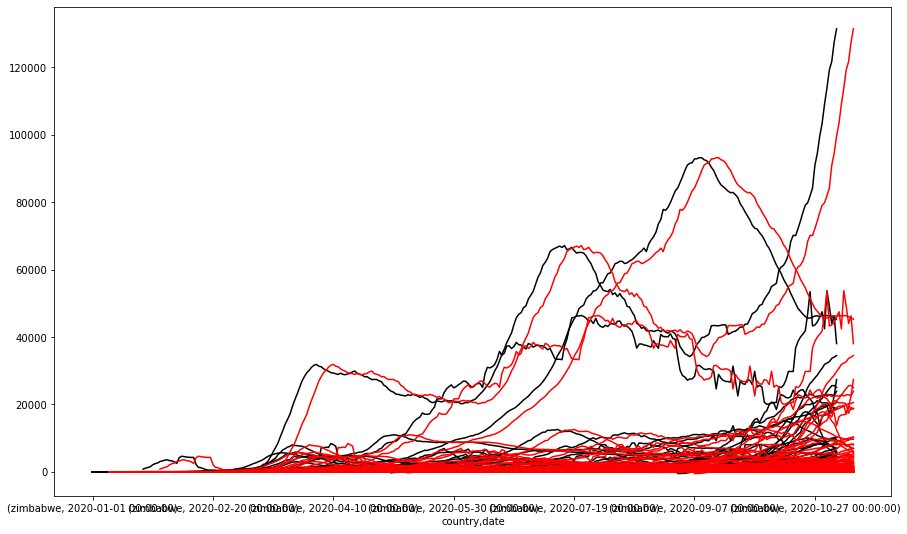

In [141]:
rolmean_case.groupby(level=0)['case_rol_mean_lag7'].plot(x=rolmean_case.index[1], color='black',label='Lagged Values'),rolmean_case.groupby(level=0)['case_count'].plot(x=rolmean_case.index[1],color='red',label='Non-lagged values')


country
afghanistan           AxesSubplot(0.125,0.125;0.775x0.755)
albania               AxesSubplot(0.125,0.125;0.775x0.755)
algeria               AxesSubplot(0.125,0.125;0.775x0.755)
andorra               AxesSubplot(0.125,0.125;0.775x0.755)
angola                AxesSubplot(0.125,0.125;0.775x0.755)
                                      ...                 
west bank and gaza    AxesSubplot(0.125,0.125;0.775x0.755)
western sahara        AxesSubplot(0.125,0.125;0.775x0.755)
yemen                 AxesSubplot(0.125,0.125;0.775x0.755)
zambia                AxesSubplot(0.125,0.125;0.775x0.755)
zimbabwe              AxesSubplot(0.125,0.125;0.775x0.755)
Name: case_rol_mean7, Length: 214, dtype: object

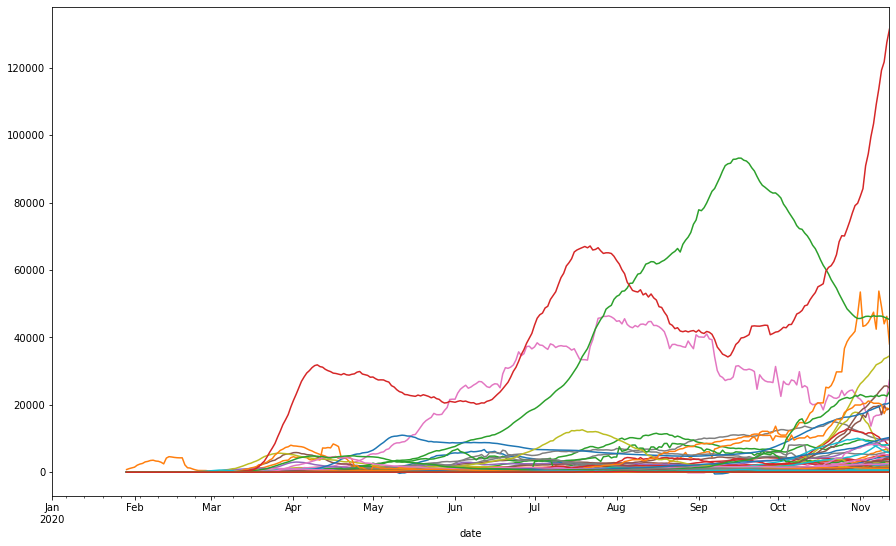

In [142]:
finaldf.set_index('date').groupby('country').case_rol_mean7.plot()

In [143]:
finaldf.columns

Index(['country', 'countrycode', 'date', 'case_count', 'death_count',
       'school_close', 'domestic_travel', 'internat_travel', 'large_gather',
       'public_events', 'stay_home', 'work_close', 'public_transpo',
       'gdp_rank', 'gdp_in_mil_us', 'smoking_ihme_2019', 'pop_2020',
       'pop_den_per_sqkm', 'un_population_division_median_age_2017',
       'ages_65_and_above_of_total_population',
       'prevalence_hivaids_sex_both_age_15_49_years_percent',
       'deaths_hivaids_sex_both_age', 'diabetes_prev_ages_20_to_79',
       'deaths_smoking_sex_both_age_age_standardized_rate',
       'cancer_prevalence', 'htn_prevalence', 'copd_dalys_per_100000',
       'obesity_ihme_2019', 'country_vulnerability', 'emergency_preparedness',
       'gov_efficiency', 'quarantine_efficiency', 'total_score',
       'mers_case_count', 'sars_case_count', 'mers_sars_sum',
       'mers_sars_quart', 'mers_sars_max', 'number_of_deathsa',
       'number_of_imported_cases', 'percent_of_imported_cases', 'c

In [144]:
# finaldf.to_excel(f'{out_data_path}\\Final COVID Data Set (Through {date}) (ver2).xlsx',index=False)

**Creating a Data Set With Just Country Codes in it to Facilitate Later Merging**

In [145]:
cc = finaldf[['country','countrycode']]
cc['dup'] = cc.duplicated('country')
cc = cc.loc[~cc.dup]
cc.drop(columns=['dup'], inplace=True)
cc.rename(columns={'countrycode':'code'}, inplace=True)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Data Set for the Linear Model of Cumulative Incidence Rates

In [146]:
gdp.rename(columns={'countrycode':'code'},inplace=True)

In [147]:
# safety

In [148]:
cum_df = pd.DataFrame(columns=['cum_case_count','cum_death_count'])
cum_df[['cum_case_count','cum_death_count']] = finaldf.groupby('country')[['case_count','death_count']].sum()
dfs = [cc,smk_die_rate, smk_die_prop,hiv_prev, hiv_death, obese, pop, pop_den, age, diabet, mers, sars]
merge = partial(pd.merge,on='code', how='outer')
control_norepeat = reduce(merge,dfs)
control_norepeat[['mers_case_count','sars_case_count']] = control_norepeat[['mers_case_count','sars_case_count']].fillna(0)
control_norepeat = mers_sars_quat_make(control_norepeat)
cum_df = cum_df.merge(control_norepeat,on='country')
cum_df.rename(columns={'population_by_country_and_region_historic_and_projections_gapminder_hyde__un':'pop_2020'},inplace=True)
cum_df['case_incid_100k'] = (cum_df.cum_case_count/cum_df.pop_2020)*100000
cum_df['death_incid_100k'] = (cum_df.cum_death_count/cum_df.pop_2020)*100000
cum_df = cum_df.merge(gdp,on=['country','code'],how='outer')
cum_df = cum_df.merge(safety, on=['country'],how='outer')
cum_df = cum_df.loc[~cum_df.cum_case_count.isnull()]
cum_df.columns

Index(['country', 'cum_case_count', 'cum_death_count', 'code',
       'deaths_smoking_sex_both_age_age_standardized_rate',
       'smoking_ihme_2019',
       'prevalence_hivaids_sex_both_age_15_49_years_percent',
       'deaths_hivaids_sex_both_age_age_standardized_rate',
       'obesity_ihme_2019', 'pop_2020', 'pop_den_per_sqkm',
       'un_population_division_median_age_2017',
       'diabetes_prevalence__of_population_ages_20_to_79', 'mers_case_count',
       'sars_case_count', 'number_of_deathsa', 'number_of_imported_cases',
       'percent_of_imported_cases', 'mers_sars_max', 'mers_sars_sum',
       'mers_sars_quart', 'case_incid_100k', 'death_incid_100k', 'ranking',
       'us dollars in mil', 'global region', 'quarantine efficiency',
       'gov efficiency', 'monitoring and detection', 'healthcare readiness',
       'country vulnerability', 'emergency preparedness', 'total score'],
      dtype='object')

In [149]:
cum_df

,country,cum_case_count,cum_death_count,code,deaths_smoking_sex_both_age_age_standardized_rate,smoking_ihme_2019,prevalence_hivaids_sex_both_age_15_49_years_percent,deaths_hivaids_sex_both_age_age_standardized_rate,obesity_ihme_2019,pop_2020,...,ranking,us dollars in mil,global region,quarantine efficiency,gov efficiency,monitoring and detection,healthcare readiness,country vulnerability,emergency preparedness,total score
0,afghanistan,42795.0,1591.0,AFG,89.891759,4.08,0.026428,1.087497,8.50,38928000.0,...,114.0,19101.0,Asia & Pacific,98.74,59.72,40.82,22.21,63.29,56.25,341.03
1,albania,26211.0,598.0,ALB,98.236114,19.11,0.001675,0.044813,12.11,2878000.0,...,123.0,15278.0,Europe,109.27,97.74,81.63,56.61,79.16,64.88,489.28
2,algeria,65108.0,2111.0,DZA,60.411873,11.08,0.037430,0.785515,17.47,43851000.0,...,55.0,169988.0,Africa,100.09,97.92,61.95,44.65,81.26,64.88,450.75
3,andorra,5616.0,75.0,AND,57.769833,14.25,0.116842,0.389653,9.23,77000.0,...,166.0,3154.0,Europe,122.42,155.95,120.57,75.50,96.86,71.44,642.73
4,angola,13053.0,315.0,AGO,87.578274,4.78,1.880777,67.955665,3.23,32866000.0,...,66.0,94635.0,Africa,100.85,76.81,60.46,36.29,72.03,56.25,402.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,west bank and gaza,60784.0,542.0,PSE,49.911366,7.88,0.005127,0.221547,15.38,5101000.0,...,126.0,14616.0,Middle East,111.13,79.33,63.43,15.17,43.56,56.25,368.87
213,western sahara,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Africa,87.71,59.89,43.10,20.53,45.44,56.25,312.93
214,yemen,2071.0,605.0,YEM,103.083377,7.61,0.037934,1.402170,8.35,29826000.0,...,102.0,27591.0,Middle east,98.95,57.06,40.70,35.89,72.30,56.25,361.15
215,zambia,17056.0,350.0,ZMB,76.977064,3.68,10.894447,137.761161,2.82,18384000.0,...,111.0,23065.0,Africa,104.48,90.66,62.21,49.68,67.34,64.88,439.25


In [150]:
finaldf.columns

Index(['country', 'countrycode', 'date', 'case_count', 'death_count',
       'school_close', 'domestic_travel', 'internat_travel', 'large_gather',
       'public_events', 'stay_home', 'work_close', 'public_transpo',
       'gdp_rank', 'gdp_in_mil_us', 'smoking_ihme_2019', 'pop_2020',
       'pop_den_per_sqkm', 'un_population_division_median_age_2017',
       'ages_65_and_above_of_total_population',
       'prevalence_hivaids_sex_both_age_15_49_years_percent',
       'deaths_hivaids_sex_both_age', 'diabetes_prev_ages_20_to_79',
       'deaths_smoking_sex_both_age_age_standardized_rate',
       'cancer_prevalence', 'htn_prevalence', 'copd_dalys_per_100000',
       'obesity_ihme_2019', 'country_vulnerability', 'emergency_preparedness',
       'gov_efficiency', 'quarantine_efficiency', 'total_score',
       'mers_case_count', 'sars_case_count', 'mers_sars_sum',
       'mers_sars_quart', 'mers_sars_max', 'number_of_deathsa',
       'number_of_imported_cases', 'percent_of_imported_cases', 'c

# Calculating the peak transmission and death dates

In [151]:
time_to_event = finaldf[['country','case_count','death_count',
                         'case_rol_mean7','death_rol_mean7','date',
                         'school_close', 'work_close', 'public_transpo',
                         'domestic_travel','large_gather','public_events', 
                         'stay_home','pop_2020','pop_den_per_sqkm', 'un_population_division_median_age_2017',
                         'ages_65_and_above_of_total_population','prevalence_hivaids_sex_both_age_15_49_years_percent',
                         'deaths_hivaids_sex_both_age', 'diabetes_prev_ages_20_to_79',
                         'deaths_smoking_sex_both_age_age_standardized_rate',
                         'cancer_prevalence', 'htn_prevalence', 'copd_dalys_per_100000',
                         'obesity_ihme_2019', 'country_vulnerability', 'emergency_preparedness',
                         'gov_efficiency', 'quarantine_efficiency', 'total_score','mers_sars_quart']].copy()

#Getting the maximum value for the rolling mean for each country
max_rol_mean_c = time_to_event.groupby('country').case_rol_mean7.max().reset_index()
max_rol_mean_c.rename(columns = {'case_rol_mean7':'case_max_rol_mean7'},inplace=True)
max_rol_mean_d = time_to_event.groupby('country').death_rol_mean7.max().reset_index()
max_rol_mean_d.rename(columns = {'death_rol_mean7':'death_max_rol_mean7'},inplace=True)
time_to_event = time_to_event.merge(max_rol_mean_c, on='country')
time_to_event = time_to_event.merge(max_rol_mean_d, on='country')


#Creating the peak death and case indicators
time_to_event['peak_case'] = 0
time_to_event['peak_death'] = 0
time_to_event.loc[time_to_event.case_rol_mean7.round(3) == time_to_event['case_max_rol_mean7'].round(3), 'peak_case'] = 1 
time_to_event.loc[time_to_event.death_rol_mean7.round(3) == time_to_event['death_max_rol_mean7'].round(3), 'peak_death'] = 1


# Creating the peak case dates
peak_dates_c = time_to_event.loc[time_to_event.peak_case == 1][['country','date']]
peak_dates_c.rename(columns={'date':'case_peak_date'},inplace=True)
    # Finding and flagging countries with multiple peaks
multiple_peak_c = peak_dates_c.country.value_counts().to_frame()
multiple_peak_c = multiple_peak_c.loc[multiple_peak_c.country > 1]
muli_peak_case_countries = multiple_peak_c.index
peak_dates_c['case_muli_peak'] = 0
for country in muli_peak_case_countries:
    peak_dates_c.loc[peak_dates_c.country== country, 'case_muli_peak'] = 1
peak_dates_c, date_offset = peak_date_cleaner(peak_dates_c, 'case_muli_peak','case_peak_date')


# Creating the peak death dates
peak_dates_d = time_to_event.loc[time_to_event.peak_death == 1][['country','date']]
peak_dates_d.rename(columns={'date':'death_peak_date'},inplace=True)
    # Finding and flagging countries with multiple peaks
multiple_peak_d = peak_dates_d.country.value_counts().head(60).to_frame()
multiple_peak_d = multiple_peak_d.loc[multiple_peak_d.country > 1]
muli_peak_death_countries = multiple_peak_d.index
peak_dates_d['death_muli_peak'] = 0
for country in muli_peak_case_countries:
    peak_dates_d.loc[peak_dates_d.country== country, 'death_muli_peak'] = 1
peak_dates_d, date_offset  = peak_date_cleaner(peak_dates_d, 'death_muli_peak','death_peak_date')  


peak_dates = peak_dates_c.merge(peak_dates_d,on='country')
time_to_event = pd.merge(left=time_to_event, right=peak_dates, on='country', how='outer')


# Setting the Post Peak Period
time_to_event.loc[time_to_event.date > time_to_event.case_peak_date, 'peak_case'] = 2
time_to_event.loc[time_to_event.date > time_to_event.death_peak_date, 'peak_death'] = 2

time_to_event.loc[time_to_event.case_peak_date == finaldf.date.dt.date.max() + pd.DateOffset(days=date_offset),'peak_case'] = 0
time_to_event.loc[time_to_event.death_peak_date == finaldf.date.dt.date.max() + pd.DateOffset(days=date_offset), 'peak_death'] = 0

# Removing all case and death counts that occurred after the peak in reports 
time_to_event.loc[time_to_event.peak_case==2, 'case_count'] = np.nan
time_to_event.loc[time_to_event.peak_death==2, 'death_count'] = np.nan


#Removing all values the occured before the 1st case report
time_to_event['case_reported'] = 0
time_to_event['death_reported'] = 0
time_to_event.loc[time_to_event.case_count > 0 ,'case_reported'] = 1
time_to_event.loc[time_to_event.death_count > 0 ,'death_reported'] = 1
time_to_event['first_case_reported'] = 0
time_to_event['first_death_reported'] = 0
time_to_event['day'] =''

In [152]:
time_to_event.loc[time_to_event.country == 'andorra'].date.max()

Timestamp('2020-11-12 00:00:00')

In [153]:
# # Identifying the Countries with two peaks the occur in consecutive days
# for countries in two_peaks_country:
#     print(peak_dates.loc[peak_dates.country == countries ])
    

## Evaluating the Countries With Multiple Peak Values

In [154]:
print(f'The number of countries with more than one date where the same peak value for rolling mean case count was calculated: {multiple_peak_c.shape[0]}')

The number of countries with more than one date where the same peak value for rolling mean case count was calculated: 28


In [155]:
print(f'The number of countries with more than one date where the same peak value for rolling mean death count was calculated: {multiple_peak_d.shape[0]}')

The number of countries with more than one date where the same peak value for rolling mean death count was calculated: 60


In [156]:
muli_peak_case_countries

Index(['marshall islands', 'equatorial guinea', 'western sahara', 'laos',
       'grenada', 'antigua and barbuda', 'seychelles', 'burundi', 'botswana',
       'vanuatu', 'gabon', 'switzerland', 'chad', 'comoros', 'ms zaandam',
       'mongolia', 'saint vincent and the grenadines', 'bhutan',
       'saint kitts and nevis', 'barbados', 'andorra', 'holy see', 'eritrea',
       'nicaragua', 'central african republic', 'ghana', 'congo (brazzaville)',
       'fiji'],
      dtype='object')

Text(0.5, 1.0, 'Countries With Multiple Peak Dates in the Rolling Mean Case Count')

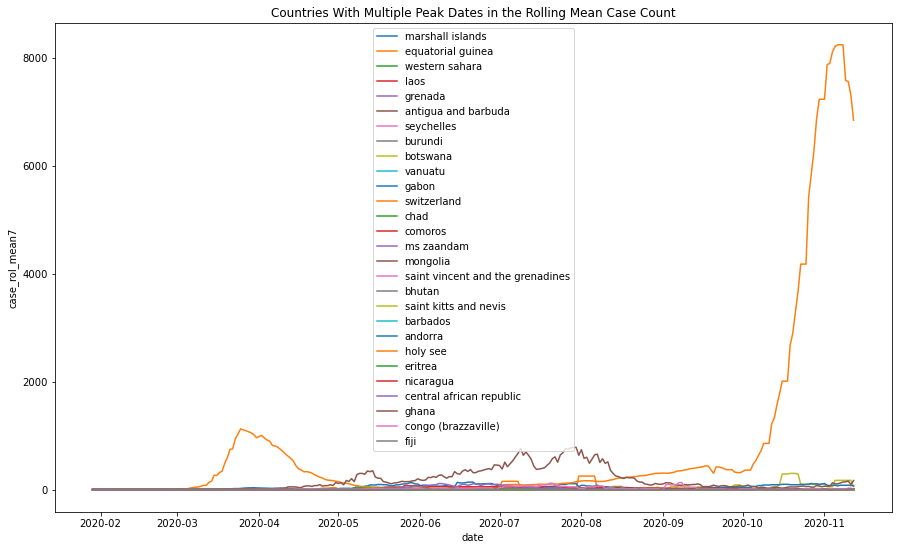

In [157]:
for countries in muli_peak_case_countries:
    sns.lineplot(y ='case_rol_mean7',x='date',data = finaldf.loc[finaldf.country ==countries],label=countries)
    plt.legend(loc='best')
plt.title('Countries With Multiple Peak Dates in the Rolling Mean Case Count')

### Low Case Count countries With More Than One Peak Case Date

In [158]:
# case_multi_peak_country = peak_dates_c.loc[(peak_dates_c.case_muli_peak == 1)].groupby('country').case_peak_date.nunique().to_frame()
# two_peaks_country = case_multi_peak_country.loc[case_multi_peak_country.case_peak_date ==2].index
# two_peaks_country

In [159]:
# rol_mean_limit = 100
# for countries in muli_peak_case_countries:
#     sns.lineplot(y ='case_rol_mean7',x='date',data = finaldf.loc[(finaldf.country ==countries) & (finaldf.groupby('country').case_rol_mean7.max() < rol_mean_limit)],label=countries)
#     plt.legend(loc='best')
# plt.title(f"""Countries With Multiple Peak Dates in the Rolling Mean Case Count & 
# A Rolling Mean Lower Than{rol_mean_limit}""")

Text(0, 0.5, 'Number of Cases')

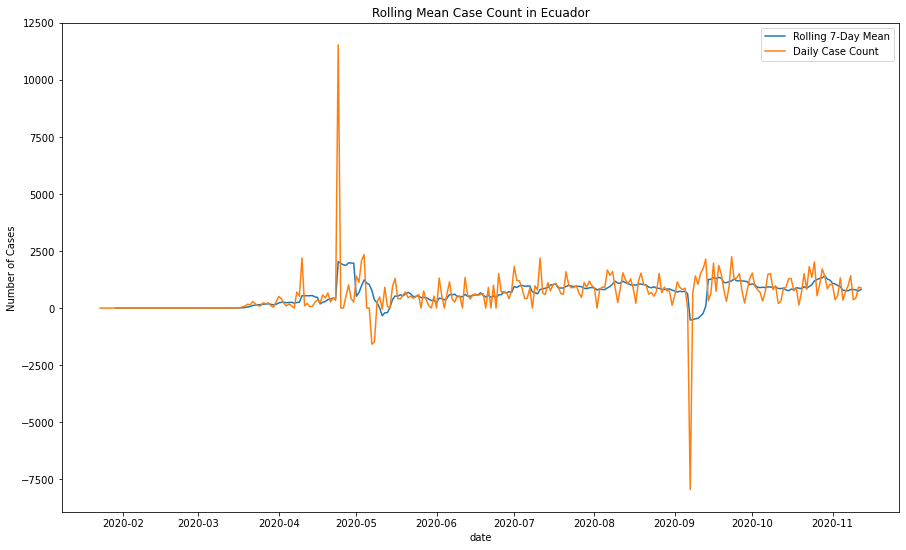

In [160]:
country = 'ecuador'
sns.lineplot(y ='case_rol_mean7',x='date' ,data = finaldf.loc[finaldf.country ==country],label='Rolling 7-Day Mean')
sns.lineplot(y ='case_count',x='date' ,data = finaldf.loc[finaldf.country ==country],label='Daily Case Count')
plt.title(f'Rolling Mean Case Count in {country[0].upper()}{country[1:]}')
plt.ylabel('Number of Cases')

In [161]:
muli_peak_death_countries

Index(['mongolia', 'timor-leste', 'solomon islands', 'bhutan', 'eritrea',
       'laos', 'marshall islands', 'dominica', 'holy see',
       'saint kitts and nevis', 'grenada', 'cambodia',
       'saint vincent and the grenadines', 'seychelles', 'vanuatu', 'burundi',
       'western sahara', 'ms zaandam', 'antigua and barbuda',
       'diamond princess', 'mauritius', 'brunei', 'taiwan', 'cyprus',
       'papua new guinea', 'lesotho', 'barbados', 'tajikistan', 'botswana',
       'monaco', 'sao tome and principe', 'guinea', 'new zealand', 'maldives',
       'singapore', 'liechtenstein', 'djibouti', 'sierra leone', 'comoros',
       'ghana', 'suriname', 'eswatini', 'fiji', 'somalia', 'congo (kinshasa)',
       'gambia', 'mali', 'tanzania', 'liberia', 'congo (brazzaville)', 'benin',
       'south korea', 'bahrain', 'burkina faso', 'japan', 'mozambique',
       'south sudan', 'guinea-bissau', 'trinidad and tobago', 'san marino'],
      dtype='object')

In [162]:
for country in time_to_event.country.unique():
    df = time_to_event.loc[time_to_event.country == country]
    date_c = df.iloc[df.case_reported.ne(0).argmax()]['date']
    date_d = df.iloc[df.death_reported.ne(0).argmax()]['date']
    time_to_event.loc[(time_to_event.country == country) & (time_to_event.date >= date_c),'first_case_reported'] = 1
    time_to_event.loc[(time_to_event.country == country) & (time_to_event.date >= date_d),'first_death_reported'] = 1
del df
time_to_event_case = time_to_event.loc[(time_to_event.first_case_reported > 0) & (time_to_event.peak_case < 2) & (time_to_event.case_muli_peak == 0)].reset_index()
time_to_event_case = time_to_event_case.drop(columns=['death_peak_date', 'case_reported', 'death_reported',
                                 'first_case_reported', 'first_death_reported','death_count',
                                 'death_rol_mean7','death_max_rol_mean7'])
time_to_event_death = time_to_event.loc[(time_to_event.first_death_reported > 0) & (time_to_event.peak_death < 2)& (time_to_event.death_muli_peak == 0)].reset_index()
time_to_event_death = time_to_event_death.drop(columns=['case_count','case_rol_mean7','case_max_rol_mean7',
                                                        'case_peak_date','case_muli_peak','death_reported', 
                                                        'first_case_reported', 'first_death_reported'])
counter = 0
# Creates the day count variable
for country in time_to_event.country.unique():
    time_to_event_case.loc[time_to_event_case.country == country ,'day'] = (time_to_event_case.loc[time_to_event_case.country == country].date - (time_to_event_case.loc[time_to_event_case.country == country].date.min() + pd.DateOffset(-1)))
    time_to_event_death.loc[time_to_event_death.country == country ,'day'] = (time_to_event_death.loc[time_to_event_death.country == country].date - (time_to_event_death.loc[time_to_event_death.country == country].date.min() + pd.DateOffset(-1)))
time_to_event_case['day_num'] = time_to_event_case.day.astype('timedelta64[D]').dt.components.days
time_to_event_death['day_num'] = time_to_event_death.day.astype('timedelta64[D]').dt.components.days

# Creating the control var composite variable

In [163]:
time_to_event_case.columns

Index(['index', 'country', 'case_count', 'case_rol_mean7', 'date',
       'school_close', 'work_close', 'public_transpo', 'domestic_travel',
       'large_gather', 'public_events', 'stay_home', 'pop_2020',
       'pop_den_per_sqkm', 'un_population_division_median_age_2017',
       'ages_65_and_above_of_total_population',
       'prevalence_hivaids_sex_both_age_15_49_years_percent',
       'deaths_hivaids_sex_both_age', 'diabetes_prev_ages_20_to_79',
       'deaths_smoking_sex_both_age_age_standardized_rate',
       'cancer_prevalence', 'htn_prevalence', 'copd_dalys_per_100000',
       'obesity_ihme_2019', 'country_vulnerability', 'emergency_preparedness',
       'gov_efficiency', 'quarantine_efficiency', 'total_score',
       'mers_sars_quart', 'case_max_rol_mean7', 'peak_case', 'peak_death',
       'case_peak_date', 'case_muli_peak', 'death_muli_peak', 'day',
       'day_num'],
      dtype='object')

### Calculating the number of observations per country

In [164]:
time_to_event_case.day_num.max(), time_to_event_death.day_num.max()

(294, 268)

In [165]:
num_obs_country = time_to_event_case.country.value_counts().to_frame()
num_obs_country.rename(columns={'country':'n_days'},inplace=True)
num_obs_country = num_obs_country.reset_index()
num_obs_country.set_index('index',inplace=True)


Text(10.049999999999997, 0.5, 'Number of Countries')

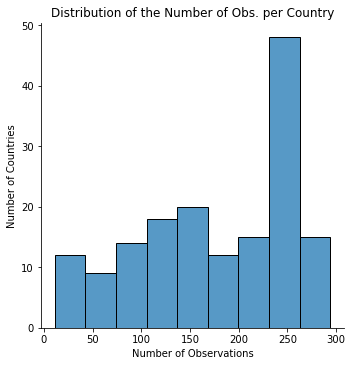

In [166]:
sns.displot(x='n_days', data=num_obs_country)
plt.title('Distribution of the Number of Obs. per Country')
plt.xlabel('Number of Observations')
plt.ylabel('Number of Countries')

In [167]:
time_to_event_case.country.value_counts().to_frame()['country'].describe()

count    163.000000
mean     179.705521
std       79.910438
min       11.000000
25%      116.500000
50%      197.000000
75%      251.000000
max      294.000000
Name: country, dtype: float64

# After PCA If not all of the variables are needed in the composite then drop them here

In [168]:
time_to_event_case[['school_close', 'work_close', 'public_transpo', 'domestic_travel',
       'large_gather', 'public_events', 'stay_home',]].describe()

,school_close,work_close,public_transpo,domestic_travel,large_gather,public_events,stay_home
count,25403.00000,25383.000000,25401.000000,25396.000000,25395.000000,25395.000000,25395.000000
mean,2.22702,1.629004,0.737254,1.145062,2.760937,1.614255,1.147667
std,1.08311,0.999001,0.786711,0.908744,1.423921,0.699217,0.939877
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.00000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000
50%,3.00000,2.000000,1.000000,1.000000,3.000000,2.000000,1.000000
75%,3.00000,2.000000,1.000000,2.000000,4.000000,2.000000,2.000000
max,3.00000,3.000000,2.000000,2.000000,4.000000,2.000000,3.000000


In [169]:
control_var_list = ['school_close','work_close','public_transpo', 'domestic_travel', 'large_gather', 'public_events','stay_home']
# control_var_list = ['school_close','work_close', 'large_gather', 'stay_home']

In [170]:
# Creating the blank strigency index variable
def si_maker(dset):
    SI = pd.DataFrame({'country':list(dset.country.unique())})
    SI.set_index('country',inplace=True)
    for var in control_var_list:
        df = dset.groupby('country')[var].value_counts().to_frame()
        df.rename(columns={var:var+'_count'},inplace=True)
        df.reset_index(inplace=True)
        df[var+'_sum'] = df[var]*df[var+'_count']
        df = df.groupby('country')[var+'_sum'].sum().to_frame()
        df = df.merge(num_obs_country,left_index=True, right_index=True)
        df['SI_'+ var] = df[var+'_sum'] /df.n_days
        df = df.filter(['SI_'+ var])
        SI = SI.merge(df,left_index=True, right_index=True,how='outer')
        
    del df
    SI['SI_sum']= SI.iloc[0:,0:].sum(axis=1)
    SI['constant'] = 100 / SI.SI_sum.max()
    SI['sdi'] = SI['constant'] * SI['SI_sum']
    SI.reset_index(inplace=True)
    SI.rename(columns={'index':'country'},inplace=True)
    return SI

In [171]:
si_case = si_maker(time_to_event_case)
si_death = si_maker(time_to_event_death)
si_cum = si_maker(time_to_event.loc[time_to_event.peak_case < 2][['country','date','school_close','work_close','public_transpo', 'domestic_travel', 'large_gather', 'public_events','stay_home']])

In [172]:
si_case.columns

Index(['country', 'SI_school_close', 'SI_work_close', 'SI_public_transpo',
       'SI_domestic_travel', 'SI_large_gather', 'SI_public_events',
       'SI_stay_home', 'SI_sum', 'constant', 'sdi'],
      dtype='object')

In [173]:
si_case.head(5)

,country,SI_school_close,SI_work_close,SI_public_transpo,SI_domestic_travel,SI_large_gather,SI_public_events,SI_stay_home,SI_sum,constant,sdi
0,afghanistan,2.446602,2.155340,1.359223,1.242718,2.407767,1.883495,1.417476,12.912621,5.543977,71.587271
1,albania,2.213710,1.846774,1.056452,0.645161,3.161290,1.862903,0.645161,11.431452,5.543977,63.375701
2,algeria,2.416031,1.721374,1.251908,1.053435,2.740458,1.465649,1.748092,12.396947,5.543977,68.728382
3,angola,2.766234,2.012987,1.064935,1.896104,3.549784,1.796537,1.506494,14.593074,5.543977,80.903659
4,argentina,2.832618,2.450644,1.828326,1.793991,3.725322,1.931330,2.030043,16.592275,5.543977,91.987184


Text(10.049999999999997, 0.5, 'Number of Countries')

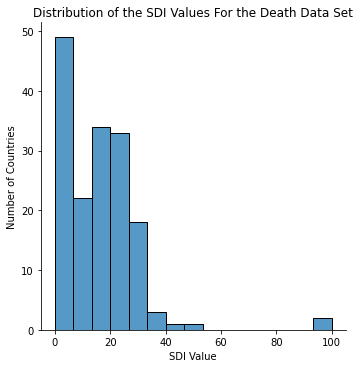

In [174]:
sns.displot(x='sdi', data=si_death)
plt.title('Distribution of the SDI Values For the Death Data Set')
plt.xlabel('SDI Value')
plt.ylabel('Number of Countries')

Text(10.049999999999997, 0.5, 'Number of Countries')

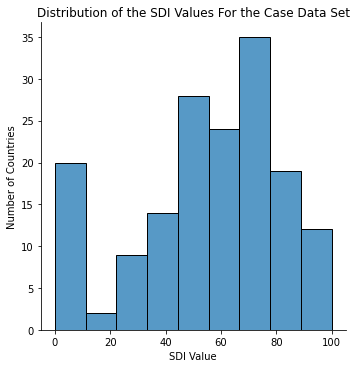

In [175]:
sns.displot(x='sdi', data=si_case)
plt.title('Distribution of the SDI Values For the Case Data Set')
plt.xlabel('SDI Value')
plt.ylabel('Number of Countries')

Text(10.049999999999997, 0.5, 'Number of Countries')

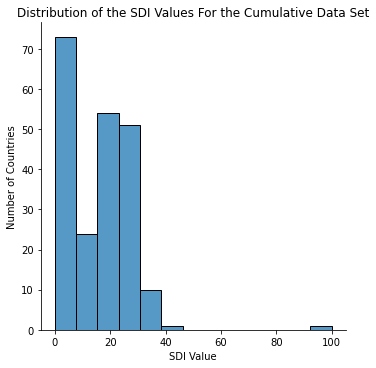

In [176]:
sns.displot(x='sdi', data=si_cum)
plt.title('Distribution of the SDI Values For the Cumulative Data Set')
plt.xlabel('SDI Value')
plt.ylabel('Number of Countries')

In [177]:
# si_case.loc[si_case.sdi  < 50].sort_values(by='sdi',ascending=False)

# Doing the Final merge of the SDI into the Cumulative and Time to event Data Sets

In [178]:
si_cum.country.nunique()

214

**Need** to create an SI for the cumulative case df The rationale behind this is that the cumulative df covers a wider date range

In [179]:
cum_df.shape

(215, 33)

In [180]:
time_to_event.peak_case.value_counts()

0    53547
2    13303
1      172
Name: peak_case, dtype: int64

In [181]:
time_to_event.country.nunique()

214

In [182]:
time_to_event_death.shape

(22305, 38)

In [183]:
cum_df = cum_df.merge(si_cum,on='country',how='inner')
cum_df.shape

(215, 43)

In [184]:
time_to_event_death = time_to_event_death.merge(si_death,on='country',how='inner')
time_to_event_death.shape

(22305, 48)

In [185]:
time_to_event_case = time_to_event_case.merge(si_case,on='country')
time_to_event_case.shape

(29292, 48)

In [186]:
cum_df.columns

Index(['country', 'cum_case_count', 'cum_death_count', 'code',
       'deaths_smoking_sex_both_age_age_standardized_rate',
       'smoking_ihme_2019',
       'prevalence_hivaids_sex_both_age_15_49_years_percent',
       'deaths_hivaids_sex_both_age_age_standardized_rate',
       'obesity_ihme_2019', 'pop_2020', 'pop_den_per_sqkm',
       'un_population_division_median_age_2017',
       'diabetes_prevalence__of_population_ages_20_to_79', 'mers_case_count',
       'sars_case_count', 'number_of_deathsa', 'number_of_imported_cases',
       'percent_of_imported_cases', 'mers_sars_max', 'mers_sars_sum',
       'mers_sars_quart', 'case_incid_100k', 'death_incid_100k', 'ranking',
       'us dollars in mil', 'global region', 'quarantine efficiency',
       'gov efficiency', 'monitoring and detection', 'healthcare readiness',
       'country vulnerability', 'emergency preparedness', 'total score',
       'SI_school_close', 'SI_work_close', 'SI_public_transpo',
       'SI_domestic_travel', 'SI_la

In [187]:
# old_names = ['SI_school_close_x', 'SI_work_close_x', 'SI_public_transpo_x',
#        'SI_domestic_travel_x', 'SI_large_gather_x', 'SI_public_events_x',
#        'SI_stay_home_x', 'SI_sum_x', 'constant_x', 'sdi_x',
#        'SI_school_close_y', 'SI_work_close_y', 'SI_public_transpo_y',
#        'SI_domestic_travel_y', 'SI_large_gather_y', 'SI_public_events_y',
#        'SI_stay_home_y', 'SI_sum_y', 'constant_y', 'sdi_y']
# new_names = ['SI_school_close', 'SI_work_close', 'SI_public_transpo',
#        'SI_domestic_travel', 'SI_large_gather', 'SI_public_events',
#        'SI_stay_home', 'SI_sum', 'constant', 'sdi',
#        'SI_school_close', 'SI_work_close', 'SI_public_transpo',
#        'SI_domestic_travel', 'SI_large_gather', 'SI_public_events',
#        'SI_stay_home', 'SI_sum', 'constant', 'sdi']
# # for n in range(0,len(old_names)):
# #     cum_df.rename(columns={old_names[n]:new_names[n]},inplace=True)
    


In [188]:
time_to_event_case.sort_values(by=['country','day'],inplace=True)
time_to_event_case['dup'] = time_to_event_case.duplicated('country',keep='last')
time_to_event_death.sort_values(by=['country','day'],inplace=True)
time_to_event_death['dup'] = time_to_event_case.duplicated('country',keep='last')

In [189]:
final_tte_case = time_to_event_case.loc[~time_to_event_case.dup].drop(columns=['dup','peak_death', 
                                                                               'death_muli_peak','school_close', 
                                                                               'case_max_rol_mean7','work_close', 
                                                                               'public_transpo', 'domestic_travel',
                                                                               'large_gather', 'public_events', 'stay_home'])
final_tte_death = time_to_event_death.loc[~time_to_event_death.dup].drop(columns=['dup','peak_case', 'case_reported', 
                                                                                  'death_max_rol_mean7', 'death_rol_mean7',
                                                                                  'school_close', 'work_close', 'public_transpo', 
                                                                                  'domestic_travel','large_gather', 'public_events', 'stay_home', ])

In [190]:
final_tte_case[['country','peak_case','day','day_num']].head(10)

,country,peak_case,day,day_num
102,afghanistan,1,103 days 00:00:00,103
350,albania,1,248 days 00:00:00,248
612,algeria,1,262 days 00:00:00,262
843,angola,1,231 days 00:00:00,231
1076,argentina,1,233 days 00:00:00,233
1323,armenia,1,247 days 00:00:00,247
1515,australia,1,192 days 00:00:00,192
1777,austria,1,262 days 00:00:00,262
2034,azerbaijan,1,257 days 00:00:00,257
2254,bahamas,1,220 days 00:00:00,220


In [191]:
final_tte_case.columns

Index(['index', 'country', 'case_count', 'case_rol_mean7', 'date', 'pop_2020',
       'pop_den_per_sqkm', 'un_population_division_median_age_2017',
       'ages_65_and_above_of_total_population',
       'prevalence_hivaids_sex_both_age_15_49_years_percent',
       'deaths_hivaids_sex_both_age', 'diabetes_prev_ages_20_to_79',
       'deaths_smoking_sex_both_age_age_standardized_rate',
       'cancer_prevalence', 'htn_prevalence', 'copd_dalys_per_100000',
       'obesity_ihme_2019', 'country_vulnerability', 'emergency_preparedness',
       'gov_efficiency', 'quarantine_efficiency', 'total_score',
       'mers_sars_quart', 'peak_case', 'case_peak_date', 'case_muli_peak',
       'day', 'day_num', 'SI_school_close', 'SI_work_close',
       'SI_public_transpo', 'SI_domestic_travel', 'SI_large_gather',
       'SI_public_events', 'SI_stay_home', 'SI_sum', 'constant', 'sdi'],
      dtype='object')

In [192]:
final_tte_death[['country','peak_death','day','day_num']].head(10)

,country,peak_death,day,day_num
102,afghanistan,0,103 days 00:00:00,103
350,albania,0,233 days 00:00:00,233
612,angola,0,199 days 00:00:00,199
843,argentina,0,221 days 00:00:00,221
1076,armenia,0,227 days 00:00:00,227
1323,austria,0,54 days 00:00:00,54
1515,austria,1,246 days 00:00:00,246
1777,bahamas,0,17 days 00:00:00,17
2034,bahrain,0,56 days 00:00:00,56
2254,bangladesh,0,57 days 00:00:00,57


# Exporting the Final Data Sets

In [193]:
final_tte_case.date.max()

Timestamp('2020-11-12 00:00:00')

In [110]:
finaldf.date.max()

Timestamp('2020-11-06 00:00:00')

In [194]:
final_tte_case.to_excel(f'{out_data_path}\\COVID Time to Peak Case (Through {date}).xlsx',index=False)
final_tte_death.to_excel(f'{out_data_path}\\COVID Time to Peak Death (Through {date}) (ver2).xlsx',index=False)
cum_df.to_excel(f'{out_data_path}\\COVID Cumulative Incidence (Through {date}) (ver2).xlsx',index=False)
finaldf.to_excel(f'{out_data_path}\\COVID Final Daily Report (Through {date}) (ver2).xlsx',index=False)

## Exploring the Visual Relationship Between Case & Death Trends & Control Measures

In [ ]:
ax = sns.lineplot(x='day_num', y='public_transpo', data=time_to_event_case)
ax2 = ax.twinx()
sns.lineplot(x='day_num', y='case_rol_mean7', data=time_to_event_case, ax=ax2)

In [ ]:
counter = 0 
country_list = []
for country in time_to_event.loc[time_to_event.pop_2020 < 1000000].country.unique():
    plt.title('Trend Line and Max Value Line Case Count')
    country_list.append(country)
    plt.figtext(0,0,country_list)
    ax = sns.lineplot(x='date' , y='case_rol_mean7', data=time_to_event.loc[time_to_event.country == country],label=country)
    plt.axhline(float(max_rol_mean_c.loc[max_rol_mean_c.country == country]['case_max_rol_mean7']))
    ax2 = ax.twinx()
    sns.lineplot(x='date' , y='peak_case', data=time_to_event.loc[time_to_event.country == country],label=f'Stay Home Status for {country}',ax=ax2,color='orange')
    
    counter += 1
    if counter == 1:
        print('DONE')
        break

In [ ]:
counter = 0 
country_list = []
for country in time_to_event.loc[time_to_event.pop_2020 < 70000].country.unique():
    plt.title('Trend Line and Max Value Line Death Count')
    country_list.append(country)
    plt.figtext(0,0,country_list)
    sns.lineplot(x='date' , y='death_rol_mean7', data=time_to_event.loc[time_to_event.country == country],label=country)
    sns.lineplot(x='date' , y='stay_home', data=time_to_event.loc[time_to_event.country == country],label=f'Stay Home Status for {country}')
    plt.axhline(float(max_rol_mean_d.loc[max_rol_mean_c.country == country]['death_max_rol_mean7']))
    counter += 1
    if counter == 1:
        print('DONE')
        break

# Checking to see How often case count values are greater than 10
doing this because the article 'Time Series Regression Model for Infectious Disease and Weather' indicated that it was important.

In [ ]:
test = pd.DataFrame()

In [ ]:
test[['country','date','case','death']] = long_df_newcontrol[['country','date','case_count','death_count']]

In [ ]:
test['g10'] = 0

In [ ]:
test.loc[test.case >=10 ,'g10']=1

In [ ]:
test.g10.value_counts()/test.shape[0]

## trying to work out country linking stuff

In [ ]:
def similar_check(q,l):
    from fuzzywuzzy import fuzz,process
    from Levenshtein import distance,ratio
    import pandas as pd
    jhu = []
    similar = []
    query = []
    for countries in q:
        results = process.extractOne(countries,list(jhu_country)) 
        if results[1] < 100:
            jhu.append(results[0])
            similar.append(results[1])
            query.append(countries)
    output = pd.DataFrame({'query_country':query, 
                          'similarity':similar,
                           'jhu_country':jhu                       
                          })
    return output

In [ ]:
# a list of the country names from each data set
jhu_country = long_case.country.unique()
ox_country = school.country.unique()
gdp_country = gdp.country
safe_country = safety.country
og_country = og_data.country

### Country Name Cleaner

## Oxford Data Country Names

In [ ]:
ox_check = similar_check(ox_country ,jhu_country)
ox_check.sort_values(by='similarity', ascending=False)

## GDP Data Country Names

In [ ]:
gdp_check = similar_check(gdp_country ,jhu_country)
gdp_check.sort_values(by='similarity', ascending=False)

## Safety Data Country Names

In [ ]:
safe_check = similar_check(safe_country ,jhu_country)
safe_check.sort_values(by='similarity', ascending=False).head(50)

## OG Data Country Names

In [ ]:
og_check = similar_check(og_country ,jhu_country)
og_check.sort_values(by='similarity', ascending=False)

# Code Grave Yard

### Importing the Oxford Control Measures Data Set (Ordinal)